In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

import gc

import warnings
warnings.filterwarnings(action='ignore')

2024-08-02 12:22:00.865597: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 12:22:00.894619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path)

### Sido Modeling (시도별 환자수 예측)

#### 1. create_date sorting 적용 / whole features

In [3]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
df_raw.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df_raw = df_raw.fillna(0)

features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

48


In [4]:
# 데이터 스케일링
scaler = StandardScaler()
df_raw[features] = scaler.fit_transform(df_raw[features])

In [5]:
# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

sequence_length = 15

In [6]:
# RNN 모델 학습 및 평가
def train_rnn_model(data, sido_cd, features, target, sequence_length):
    data_sido = data[data['sido_cd'] == sido_cd]
    X, y, dates = create_sequences(data_sido, features, target, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
    rnn_model.add(Dense(1))
    rnn_model.compile(optimizer='adam', loss='mse')
    rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    
    rnn_predictions = rnn_model.predict(X_test).flatten()
    rnn_mae = mean_absolute_error(y_test, rnn_predictions)
    rnn_mse = mean_squared_error(y_test, rnn_predictions)
    rnn_r2 = r2_score(y_test, rnn_predictions)
    
    # 메모리 초기화
    del rnn_model
    gc.collect()
    
    return {'mae': rnn_mae, 'mse': rnn_mse, 'r2': rnn_r2}

In [7]:
# LSTM 모델 학습 및 평가
def train_lstm_model(data, sido_cd, features, target, sequence_length):
    data_sido = data[data['sido_cd'] == sido_cd]
    X, y, dates = create_sequences(data_sido, features, target, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    
    lstm_predictions = lstm_model.predict(X_test).flatten()
    lstm_mae = mean_absolute_error(y_test, lstm_predictions)
    lstm_mse = mean_squared_error(y_test, lstm_predictions)
    lstm_r2 = r2_score(y_test, lstm_predictions)
    
    # 메모리 초기화
    del lstm_model
    gc.collect()
    
    return {'mae': lstm_mae, 'mse': lstm_mse, 'r2': lstm_r2}

In [8]:
# RandomForest 모델 학습 및 평가
def train_rf_model(data, sido_cd, features, target, sequence_length):
    data_sido = data[data['sido_cd'] == sido_cd]
    X, y, dates = create_sequences(data_sido, features, target, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=11)
    rf_model.fit(X_train_2d, y_train)
    
    rf_predictions = rf_model.predict(X_test_2d)
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_r2 = r2_score(y_test, rf_predictions)
    
    # 메모리 초기화
    del rf_model
    gc.collect()
    
    return {'mae': rf_mae, 'mse': rf_mse, 'r2': rf_r2}

In [9]:
# XGBoost 모델 학습 및 평가
def train_xgb_model(data, sido_cd, features, target, sequence_length):
    data_sido = data[data['sido_cd'] == sido_cd]
    X, y, dates = create_sequences(data_sido, features, target, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    
    xgb_model = XGBRegressor(n_estimators=100, random_state=11)
    xgb_model.fit(X_train_2d, y_train)
    
    xgb_predictions = xgb_model.predict(X_test_2d)
    xgb_mae = mean_absolute_error(y_test, xgb_predictions)
    xgb_mse = mean_squared_error(y_test, xgb_predictions)
    xgb_r2 = r2_score(y_test, xgb_predictions)
    
    # 메모리 초기화
    del xgb_model
    gc.collect()
    
    return {'mae': xgb_mae, 'mse': xgb_mse, 'r2': xgb_r2}

In [11]:
# 시도별 결과 저장 딕셔너리
sido_rnn = {}
# 시도별 모델 학습 및 평가
sido_cds = df_raw['sido_cd'].unique()
for sido_cd in sido_cds:
    print(f'Processing {sido_cd}...')
    sido_rnn[sido_cd] = {
        'RNN': train_rnn_model(df_raw, sido_cd, features, target, sequence_length)
    }

Processing 31...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 37.9625 - val_loss: 19.7920
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.8784 - val_loss: 15.9415
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1850 - val_loss: 16.5312
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.5301 - val_loss: 14.0475
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.0530 - val_loss: 12.8455
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.5821 - val_loss: 13.3400
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2482 - val_loss: 12.1331
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.3441 - val_loss: 12.4401
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.9440 - val_loss: 12.2831
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.8242 - val_loss: 11.6124
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.8353 - val_loss: 12.0222
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━

In [13]:
# 시도별 결과 저장 딕셔너리
sido_lstm = {}
# 시도별 모델 학습 및 평가
sido_cds = df_raw['sido_cd'].unique()
for sido_cd in sido_cds:
    print(f'Processing {sido_cd}...')
    sido_lstm[sido_cd] = {
        'LSTM': train_lstm_model(df_raw, sido_cd, features, target, sequence_length)
    }

Processing 31...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 38.3176 - val_loss: 17.2804
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6606 - val_loss: 15.2218
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.7959 - val_loss: 11.5704
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4760 - val_loss: 11.5869
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.3837 - val_loss: 9.1135
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.2152 - val_loss: 11.8101
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2097 - val_loss: 9.3373
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.4541 - val_loss: 10.5708
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8572 - val_loss: 10.8156
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5176 - val_loss: 6.9292
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4243 - val_loss: 8.5730
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [15]:
# 시도별 결과 저장 딕셔너리
sido_xgb = {}
# 시도별 모델 학습 및 평가
sido_cds = df_raw['sido_cd'].unique()
for sido_cd in sido_cds:
    print(f'Processing {sido_cd}...')
    sido_xgb[sido_cd] = {
        'XGBoost': train_xgb_model(df_raw, sido_cd, features, target, sequence_length)
    }

Processing 31...
Processing 23...
Processing 38...
Processing 26...
Processing 24...
Processing 25...
Processing 32...
Processing 39...
Processing 21...
Processing 11...
Processing 36...
Processing 29...
Processing 37...
Processing 35...
Processing 22...
Processing 33...
Processing 34...


In [16]:
# 데이터를 정리하여 하나의 데이터프레임으로 변환합니다.
def combine_models(sido_dict, model_name):
    records = []
    for sido, metrics in sido_dict.items():
        for model, scores in metrics.items():
            record = {'sido': sido, 'model': model_name}
            record.update(scores)
            records.append(record)
    return records

# RNN, LSTM, XGB 데이터를 결합
rnn_records = combine_models(sido_rnn, 'RNN')
lstm_records = combine_models(sido_lstm, 'LSTM')
xgb_records = combine_models(sido_xgb, 'XGB')

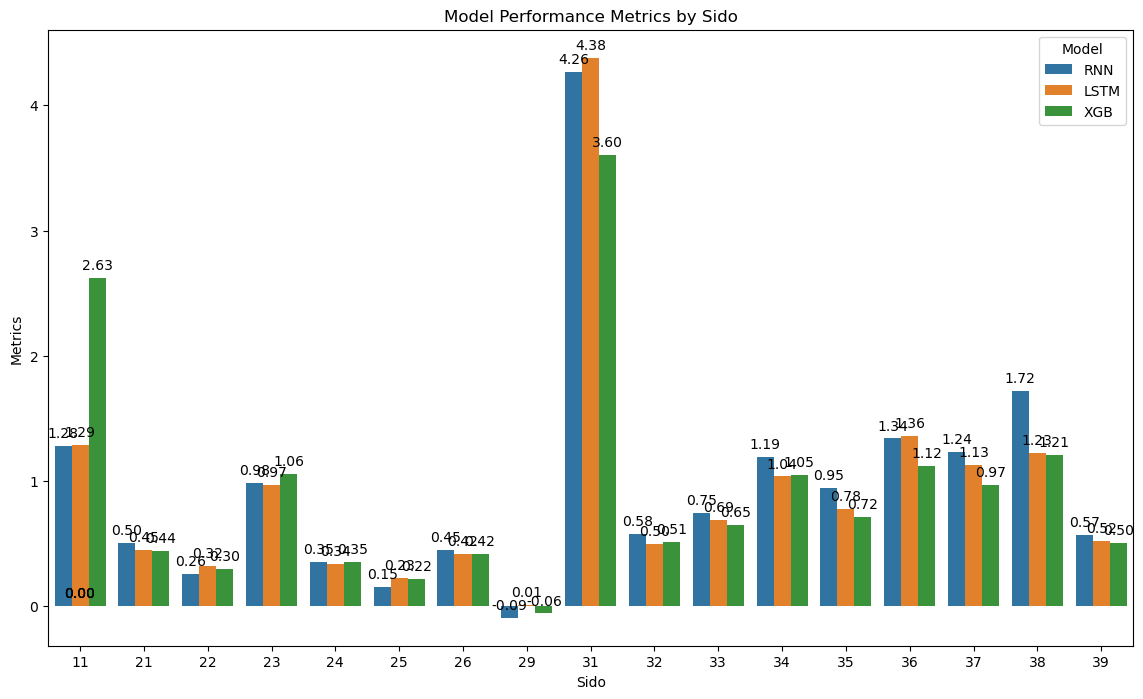

In [19]:
# 데이터프레임 생성
df = pd.DataFrame(rnn_records + lstm_records + xgb_records)

# 데이터프레임을 melt하여 시각화 준비
df_melted = df.melt(id_vars=['sido', 'model'], value_vars=['mae', 'mse', 'r2'],
                    var_name='metric', value_name='value')

# 시각화
plt.figure(figsize=(14, 8))
sns.barplot(x='sido', y='value', hue='model', data=df_melted, ci=None)

# bar 위에 값 표시
for p in plt.gca().patches:
    plt.gca().annotate(format(p.get_height(), '.2f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.title('Model Performance Metrics by Sido')
plt.xlabel('Sido')
plt.ylabel('Metrics')
plt.legend(title='Model')
plt.show()

In [ ]:
# # 시도별 결과 저장 딕셔너리
# sido_rf = {}
# # 시도별 모델 학습 및 평가
# sido_cds = df_raw['sido_cd'].unique()
# for sido_cd in sido_cds:
#     print(f'Processing {sido_cd}...')
#     sido_rf[sido_cd] = {
#         'RandomForest': train_rf_model(df_raw, sido_cd, features, target, sequence_length)
#     }

In [ ]:
dt_map = {'39': '제주특별자치도', '32': '강원특별자치도', '25': '대전광역시','21': '부산광역시',
    '24': '광주광역시','26': '울산광역시', '38': '경상남도','23': '인천광역시',
    '31': '경기도','33': '충청북도', '22': '대구광역시','35': '전북특별자치도',
    '37': '경상북도','29': '세종특별자치시','36': '전라남도','11': '서울특별시','34': '충청남도'
}